In [4]:
import csv
import json
import os
import re
import sys

from PIL import Image, ImageFilter
import imageio
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LogisticRegression
from scipy import ndimage as ndi
from skimage import feature
from scipy.fftpack import rfft, irfft, fftfreq, rfftfreq
from scipy import interpolate

def file_tree(start):
    """Generate file list in directory"""
    file_list = []
    for root, dirs, files in os.walk(start):
        for f in files:
            if f[0] != '.':
                file_list.append(f)
    return file_list


def process_data(data):
    """Process JSON data"""
    attr = data['attributes']

    timestamp = attr['timestamp']
    message = attr['message']
    author = attr['from']
    turbo = attr['tags']['turbo']
    sub = attr['tags']['subscriber']

    try:
        emotes = attr['tags']['emotes']
        emote_count = sum([len(emotes[key]) for key in emotes.keys()])
    except:
        emote_count = 0
    
    row = {
        'timestamp': timestamp,
        'author': author,
        'message': message,
        'turbo': turbo,
        'sub': sub,
        'emote_count': emote_count
    }

    return row


def high_pass_filter(freq, amp, min_freq):
    df = pd.DataFrame(amp, index=freq, columns=['Amplitude'])
    df = df.copy()
    df[df.index < min_freq] = 0
    return df

def low_pass_filter(freq, amp, max_freq):
    df = pd.DataFrame(amp, index=freq, columns=['Amplitude'])
    df = df.copy()
    df[df.index > max_freq] = 0
    return df

def round_to_val(x, val=30):
    return int(np.round(x/val) * val)

def build_time_frame(ts, before=60, after=10):
    return [ts-before, ts+after]

def build_time_window(ts, before=60, after=10):
    return np.arange(ts-before, ts+after)

def fix_overlap(intervals):
    all_vals = [list(np.arange(interval[0], interval[1]+1)) for interval in intervals]
    all_vals = sorted(list(set([v for row in all_vals for v in row])))
    intervals = []
    start = 0
    for i in range(0, len(all_vals)-1):
        if not start:
            start = all_vals[i]
        elif all_vals[i+1] - all_vals[i] > 1:
            intervals.append([start, all_vals[i]])
            start = 0
        elif i + 1 == len(all_vals) - 1:
            intervals.append([start, all_vals[i+1]])
    return intervals

In [17]:
# Set filename
filename = '/Volumes/Passport/LiveBeat/video/dota2ti_v29880976_720p30.mp4'

# Get video id
video_id = re.findall('v\d+', filename)[0]

# Open file handle
vid = imageio.get_reader(filename, 'ffmpeg')

# Get metadata
meta = vid.get_meta_data()
fps = int(meta['fps'])
nframes = meta['nframes']
frames = np.arange(0, int(nframes), 1)

# Close video
vid.close()

# Convert frames to seconds and initialize data frame
values = [0] * int(len(frames))
df = pd.DataFrame(values).reset_index()
df.columns = ['second', 'game']

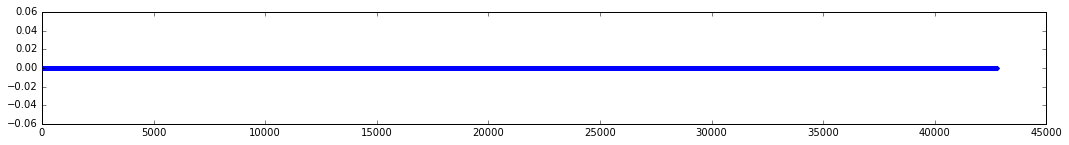

In [18]:
fig, ax1 = plt.subplots(figsize=(18,2))
ax1.plot(df.index, df['game'], '.b')

In [19]:
time_frames = [[4640,4930],
[7250,7540],
[9570,10150],
[10440,10730],
[12180,12760],
[13630,13920],
[14500,15950],
[17690,18560],
[19430,19720],
[20010,20300],
[20590,20880],
[21170,21460],
[21750,22330],
[22620,23490],
[24360,25230],
[25810,26390],
[26680,27550],
[27840,29290],
[29580,29870],
[30160,30450],
[30740,31610],
[32190,32480],
[33060,34510],
[35670,35960],
[37120,37410],
[37990,38570],
[40310,40890],
]

       second  game
42770   42770     0
42771   42771     0
42772   42772     0
42773   42773     0
42774   42774     0


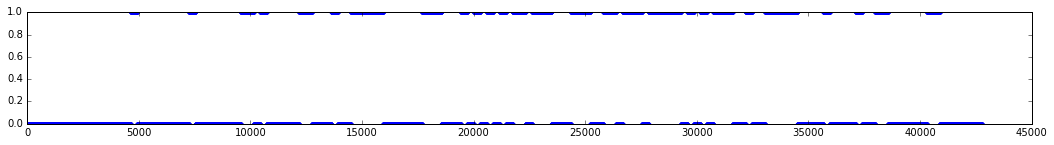

In [20]:
print(df.tail())
df['game'] = 0
for row in time_frames:
    start, stop = row
    df.loc[(df.index >= start) & (df.index < stop), 'game'] = 1

fig, ax1 = plt.subplots(figsize=(18,2))
ax1.plot(df.index, df['game'], '.b')

In [239]:
time_frames

[[4589, 4691],
 [4693, 4876],
 [4878, 5214],
 [5216, 5447],
 [5449, 5691],
 [5693, 5849],
 [5879, 6888],
 [6890, 6931],
 [6933, 6948],
 [6950, 7457],
 [7459, 7460],
 [7463, 7469],
 [8935, 9060],
 [9067, 9163],
 [9165, 9227],
 [9229, 9308],
 [9310, 9463],
 [9465, 9701],
 [9709, 9822],
 [9832, 9964],
 [9966, 10076],
 [10078, 10300],
 [10303, 10601],
 [10604, 10649],
 [10654, 11064],
 [11066, 11780],
 [11782, 11859],
 [11861, 11935],
 [11937, 11938],
 [11940, 12123],
 [12125, 12187],
 [12190, 12193],
 [12195, 12196],
 [12199, 12204],
 [14935, 14992],
 [14994, 15340],
 [15342, 15343],
 [15345, 15461],
 [15465, 15949],
 [15951, 15985],
 [16311, 16400],
 [16402, 16810],
 [16812, 17103],
 [17105, 17231],
 [18891, 19112],
 [19114, 19289],
 [19291, 19310],
 [19313, 19347],
 [19349, 19353],
 [19355, 19447],
 [19452, 19453],
 [19455, 19697],
 [19699, 19751],
 [19757, 19760],
 [19762, 19946],
 [19960, 19964],
 [19966, 19969],
 [24467, 24570],
 [24573, 24575],
 [24577, 24696],
 [24698, 24717],
 [24